In [1]:
!nvidia-smi

Wed Mar 20 10:45:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

import pathlib
import shutil
import tempfile

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

  Preparing metadata (setup.py) ... done
Version:  2.15.0
Hub version:  0.16.1
GPU is available


In [3]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', compression = 'zip', low_memory = False)
df.shape

(1306122, 3)

<Axes: title={'center': 'Target distribution'}, ylabel='Frequency'>

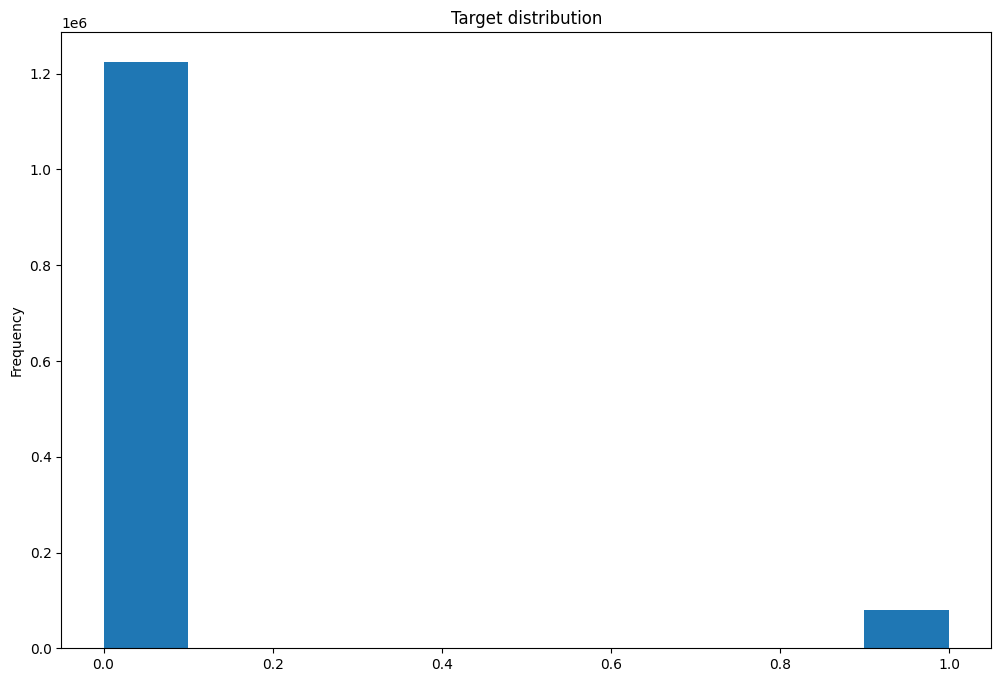

In [4]:
df['target'].plot(kind='hist', title='Target distribution')

In [5]:
from sklearn.model_selection import train_test_split
train_df, remaining = train_test_split(df, random_state= 42, train_size=0.01, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.001,stratify=remaining.target.values)
train_df.shape, valid_df.shape

((13061, 3), (1293, 3))

In [6]:
train_df.target.head(15).values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [7]:
train_df.question_text.head(15).values

array(['What is your experience living in Venezuela in the current crisis? (2018)',
       'In which state/city the price of property is highest?',
       'Do rich blacks also call poor whites, “White Trash”?',
       'Should my 5 yr old son and 2 yr old daughter spend the summer with their father, after a domestic violent relationship?',
       'Why do we have parents?',
       'Do we experience ghost like Murphy did in Interstellar?',
       'Are Estoniano women beautiful?',
       'There was a Funny or Die video called Sensitivity Hoedown that got pulled. Does anyone know why?',
       'Is it a good idea to go in fully mainstream classes, even if I have meltdowns that might disrupt people?',
       'What classifies a third world country as such?',
       'Is being a pilot safe?',
       'Who is Illiteratendra Modi? Why does he keep with him a Rs 1 lakh pen?',
       'Have modern management strategies such as Total supply Chain Management applied to education? Can they be?',
       '

In [33]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [21]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
    hub_layer = hub.KerasLayer(module_url, input_shape=[], output_shape=[embed_size], dtype=tf.string, trainable=trainable)

    model = tf.keras.models.Sequential([
        hub_layer,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])
    model.summary()
    history = model.fit(train_df['question_text'], train_df['target'],
                        epochs=100,
                        batch_size=32,
                        validation_data=(valid_df['question_text'], valid_df['target']),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'),
                                   tf.keras.callbacks.TensorBoard(logdir/name)],
                        verbose=0)
    return history


In [11]:
histories = {}

In [37]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [38]:
histories['universal-sentence-encoder-large'] = train_and_evaluate_model(module_url, embed_size=512, name='universal-sentence-encoder-large',
                                                                     trainable=False)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_6 (KerasLayer)  (None, 512)               147354880 
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 147502721 (562.68 MB)
Trainable params: 147841 (577.50 KB)
Non-trainable params: 147354880 (562.11 MB)
_________________________________________________________________


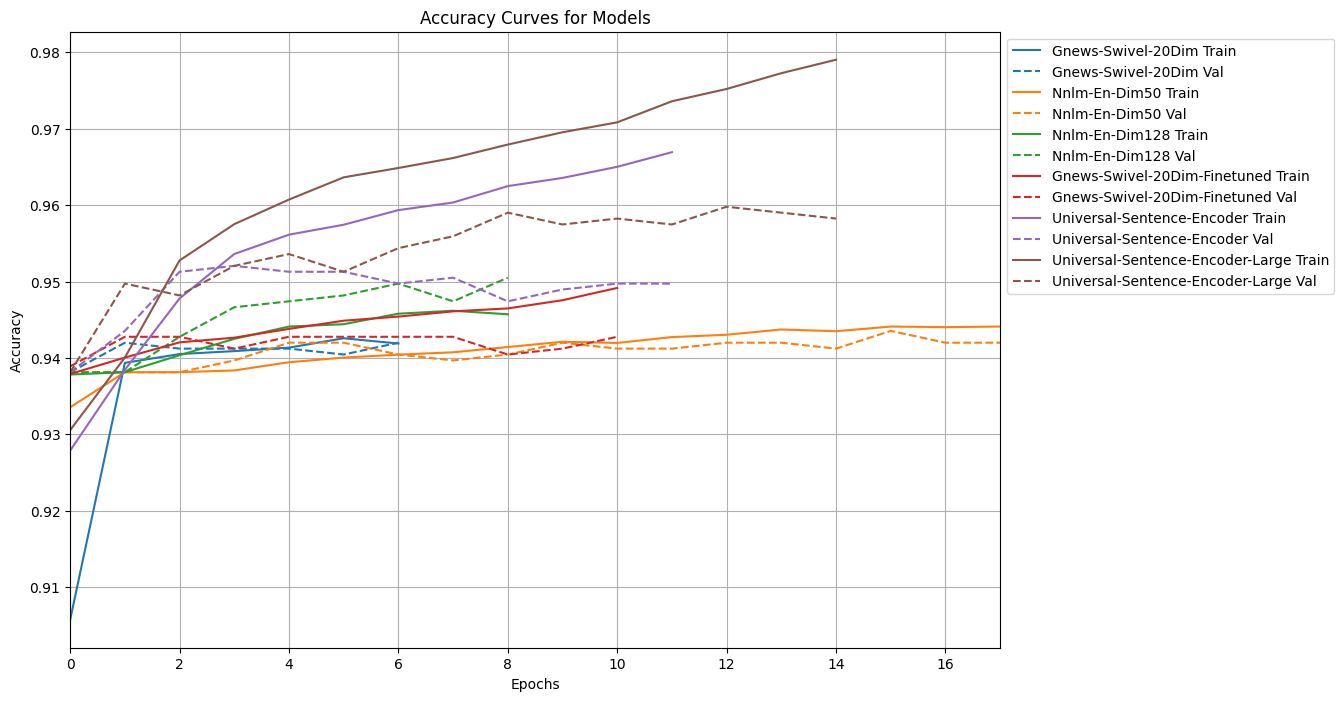

In [39]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

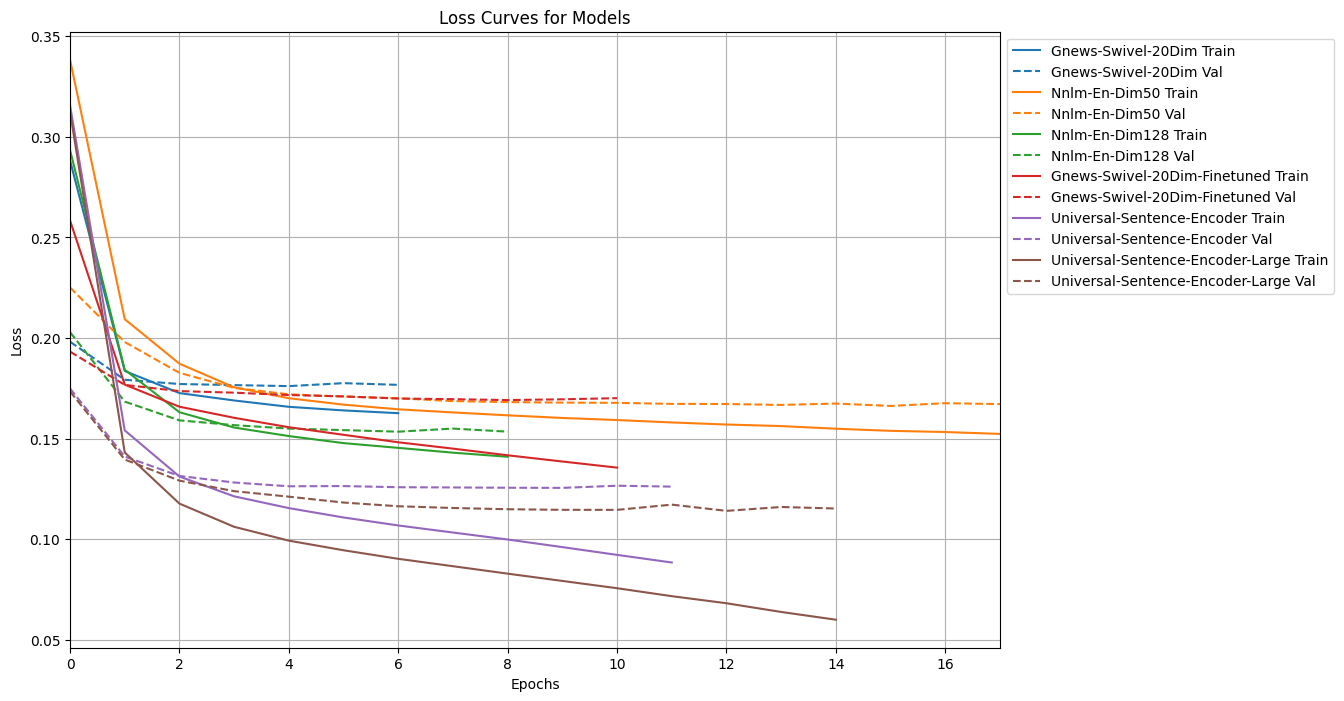

In [40]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

In [46]:
%reload_ext tensorboard

%tensorboard --logdir {logdir}

<IPython.core.display.Javascript object>